# Optimization pipeline

## Input blocks data

In [1]:
import geopandas as gpd

blocks = gpd.read_parquet('./data/blocks.parquet')[['geometry']]
crs = blocks.estimate_utm_crs()
blocks = blocks.to_crs(crs)
blocks.head()

,geometry
0,"POLYGON ((354918.622 6625258.829, 354901.464 6..."
1,"POLYGON ((355412.142 6623378.149, 355411.700 6..."
2,"POLYGON ((353934.329 6625429.433, 353923.453 6..."
3,"POLYGON ((355099.099 6623847.765, 355074.808 6..."
4,"POLYGON ((352766.168 6621954.748, 352744.412 6..."


## Processing land use

In [2]:
zones = gpd.read_parquet('./data/PZZ_2023.parquet')[['geometry', 'functional_zone_type']]
zones = zones.to_crs(crs)
zones['zone'] = zones['functional_zone_type'].apply(lambda fzt : fzt['id'])
zones.head()

,geometry,functional_zone_type,zone
0,"MULTIPOLYGON (((334149.354 6637948.405, 334200...","{'id': 2, 'name': 'recreation', 'nickname': 'Р...",2
1,"MULTIPOLYGON (((341018.126 6668199.952, 340919...","{'id': 2, 'name': 'recreation', 'nickname': 'Р...",2
2,"MULTIPOLYGON (((306834.478 6679423.253, 306831...","{'id': 2, 'name': 'recreation', 'nickname': 'Р...",2
3,"MULTIPOLYGON (((358884.702 6656481.260, 358823...","{'id': 7, 'name': 'business', 'nickname': 'Общ...",7
4,"MULTIPOLYGON (((307156.289 6679589.554, 307081...","{'id': 2, 'name': 'recreation', 'nickname': 'Р...",2


In [3]:
from lu_igi.models.land_use import LandUse

land_use_ids_mapping = {
    1 : LandUse.RESIDENTIAL,
    2 : LandUse.RECREATION,
    3 : LandUse.SPECIAL,
    4 : LandUse.INDUSTRIAL,
    5 : LandUse.AGRICULTURE,
    6 : LandUse.TRANSPORT,
    7 : LandUse.BUSINESS,
    10 : LandUse.RESIDENTIAL,
    11 : LandUse.RESIDENTIAL,
    12 : LandUse.RESIDENTIAL,
    13 : LandUse.RESIDENTIAL,
}

zones = zones[zones['zone'].isin(land_use_ids_mapping.keys())]

In [4]:
from lu_igi.preprocessing.land_use import process_land_use

blocks = process_land_use(blocks, zones, land_use_ids_mapping, min_intersection_share=0.3) # сколько требуется пересечения, чтобы присвоить лендюз
blocks.head()

2025-02-16 14:02:20.914 | INFO     | lu_igi.preprocessing.land_use:_validate_input:19 - Validating input
2025-02-16 14:02:20.937 | INFO     | lu_igi.preprocessing.land_use:_process_zones:26 - Processing functional zones
2025-02-16 14:02:20.939 | INFO     | lu_igi.preprocessing.land_use:process_land_use:35 - Intersecting geometries
2025-02-16 14:02:22.443 | INFO     | lu_igi.preprocessing.land_use:process_land_use:55 - Calculating shares
2025-02-16 14:02:34.724 | SUCCESS  | lu_igi.preprocessing.land_use:process_land_use:59 - Shares calculated


,geometry,shares,land_use
0,"POLYGON ((354918.622 6625258.829, 354901.464 6...",{},None
1,"POLYGON ((355412.142 6623378.149, 355411.700 6...",{},None
2,"POLYGON ((353934.329 6625429.433, 353923.453 6...",{LandUse.RECREATION: 0.8509049044855612},LandUse.RECREATION
3,"POLYGON ((355099.099 6623847.765, 355074.808 6...",{},None
4,"POLYGON ((352766.168 6621954.748, 352744.412 6...",{LandUse.RECREATION: 0.7546893371907889},LandUse.RECREATION


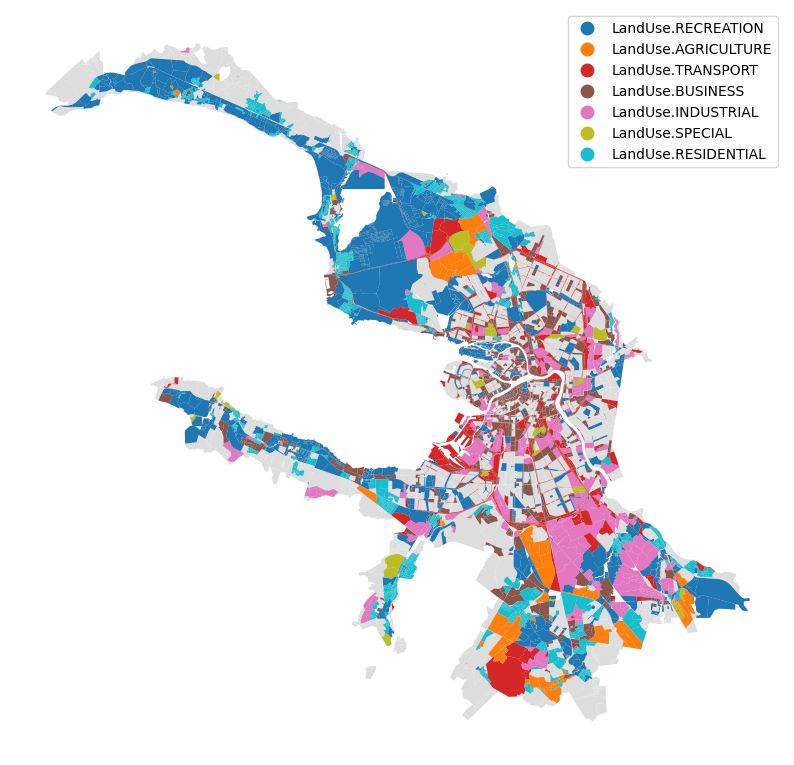

In [5]:
ax = blocks.plot(color='#ddd', figsize=(10,10))
blocks.plot(ax=ax, column='land_use', legend=True)
ax.set_axis_off()

## Generating adjacency graph

In [6]:
from lu_igi.preprocessing.graph import generate_adjacency_graph, save_graph, load_graph

graph = generate_adjacency_graph(blocks)

2025-02-16 14:02:38.780 | INFO     | lu_igi.preprocessing.graph:generate_adjacency_graph:65 - Validating input
2025-02-16 14:02:39.391 | INFO     | lu_igi.preprocessing.graph:_generate_adjacency_edges:47 - Generating edges
100%|██████████| 106850/106850 [00:09<00:00, 11275.73it/s]
2025-02-16 14:02:53.684 | SUCCESS  | lu_igi.preprocessing.graph:generate_adjacency_graph:79 - Graph successfully generated


In [7]:
graph.graph

{'crs': <Projected CRS: EPSG:32636>
 Name: WGS 84 / UTM zone 36N
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
 - bounds: (30.0, 0.0, 36.0, 84.0)
 Coordinate Operation:
 - name: UTM zone 36N
 - method: Transverse Mercator
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich}

## Project blocks selection

All blocks should be included if the territory is the whole graph

In [8]:
project = gpd.read_file('./data/project.geojson').to_crs(crs)
project.geometry = project.buffer(5)
blocks_ids = blocks.sjoin(project, predicate='within').index.to_list()
blocks_ids

[1122,
 1123,
 1163,
 1165,
 1166,
 1273,
 1274,
 1275,
 1561,
 1562,
 2409,
 2998,
 3136,
 3268,
 4340,
 4371,
 5618,
 6607,
 6961,
 8540,
 9194,
 9195,
 9196]

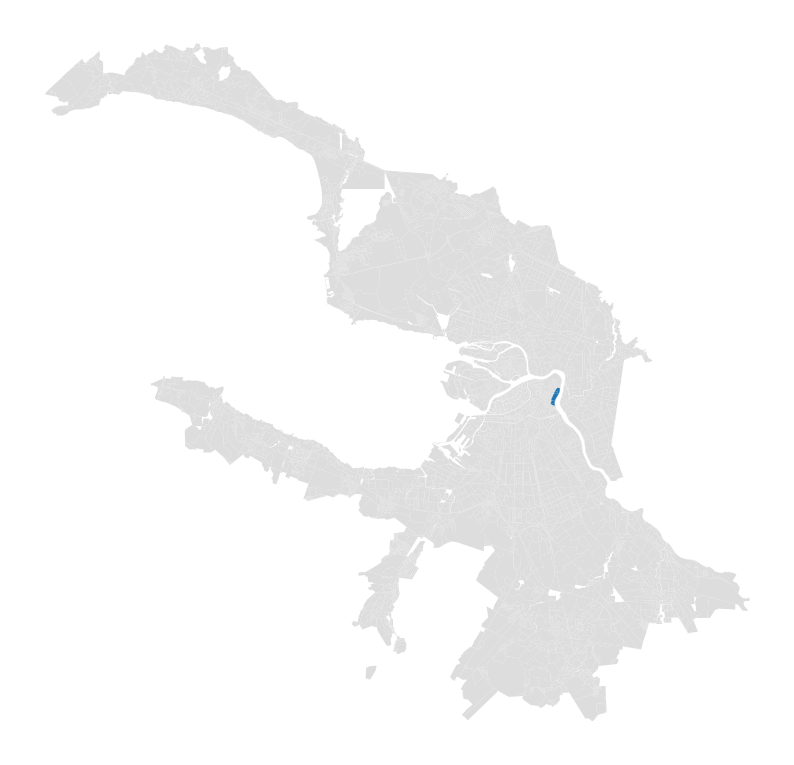

In [9]:
ax = blocks.plot(color='#ddd', figsize=(10,10))
blocks.loc[blocks_ids].plot(ax=ax)
ax.set_axis_off()

## Optimization

In [10]:
from lu_igi.optimization.optimizer import Optimizer

optimizer = Optimizer(graph)

100%|██████████| 106850/106850 [00:00<00:00, 194355.56it/s]


In [11]:
from lu_igi.optimization.problem import FitnessType
from lu_igi.models.land_use import LandUse

target_lu_shares = {
    LandUse.RESIDENTIAL : 0.5,
    LandUse.RECREATION : 0.3,
    LandUse.BUSINESS : 0.2,
    LandUse.INDUSTRIAL : 0,
    LandUse.SPECIAL : 0,
    LandUse.AGRICULTURE : 0
}

result_df = optimizer.run(blocks_ids, target_lu_shares, n_eval=5_000, verbose=False)

## Output

`result_df` represents the best obtained population (Paretto front) sorted by `FitnessType.SHARE_MSE`

In [12]:
result_df

,solution,fitness,assigned_land_use,Близость к целевому состоянию,Риск дорогой ревитализации,Конфликт размещения функциональных зон
0,"[0.19891649391607402, 2.0, 6.0, 0.424959495922...","[0.0013008495278546413, 0.0, 0.6421504860166657]","{1122: LandUse.RESIDENTIAL, 1123: LandUse.RECR...",0.001301,0.0,0.642150
2,"[0.19891649391607402, 2.0, 0.07407680787654458...","[0.0013011283389718793, 0.0, 0.3087658791501148]","{1122: LandUse.RESIDENTIAL, 1123: LandUse.RECR...",0.001301,0.0,0.308766
6,"[0.19891649391607402, 2.0, 0.07407680787654458...","[0.002668875580622514, 0.0, 0.30500543225979393]","{1122: LandUse.RESIDENTIAL, 1123: LandUse.RECR...",0.002669,0.0,0.305005
3,"[0.03321477509297294, 2.0, 1.0, 3.049617503605...","[0.06527828602849883, 0.0, 0.19497670268638304]","{1122: LandUse.RESIDENTIAL, 1123: LandUse.RECR...",0.065278,0.0,0.194977
8,"[4.0, 2.0, 1.0, 4.0, 1.0, 0.0, 1.0, 0.0, 5.0, ...","[0.09953492267769135, 0.0, 0.1344119266165745]","{1122: LandUse.INDUSTRIAL, 1123: LandUse.RECRE...",0.099535,0.0,0.134412
9,"[0.0, 2.0, 0.011742981210717263, 0.07271529834...","[0.16576508605739673, 0.0, 0.04346723145903223]","{1122: LandUse.RESIDENTIAL, 1123: LandUse.RECR...",0.165765,0.0,0.043467
7,"[4.0, 2.0, 0.0, 0.0, 5.0, 2.0, 6.0, 1.0, 5.0, ...","[0.24199220543245165, 0.0, 0.005342795472053933]","{1122: LandUse.INDUSTRIAL, 1123: LandUse.RECRE...",0.241992,0.0,0.005343
4,"[4.0, 2.0, 6.0, 5.0, 5.0, 2.0, 6.0, 1.0, 5.0, ...","[0.26640214144101604, 0.0, 0.0009640173271920004]","{1122: LandUse.INDUSTRIAL, 1123: LandUse.RECRE...",0.266402,0.0,0.000964
5,"[1.0, 2.0, 3.0, 1.0, 3.0, 2.0, 6.0, 1.0, 0.0, ...","[0.4053926051012128, 0.0, 0.0007649574801052659]","{1122: LandUse.BUSINESS, 1123: LandUse.RECREAT...",0.405393,0.0,0.000765
1,"[1.0, 2.0, 3.0, 6.0, 4.0, 2.0, 1.0, 6.0, 5.0, ...","[0.418463914611349, 0.0, 8.854145303635449e-05]","{1122: LandUse.BUSINESS, 1123: LandUse.RECREAT...",0.418464,0.0,0.000089


We can expand the result to obtain `list[dict]` of all the solutions.

Each `dict` consists of the following data:
- `FitnessType.SHARE_MSE.value() : float` - obtained land use share value (the less the better)
- `FitnessType.TRANSITION.value() : float` - obtained transition risk value (the less the better)
- `FitnessType.ADJACENCY_PENALTY.value() : float` - obtained adjacency penalty value (the less ~~i know~~ the better)
- `gdf : gpd.GeoDataFrame` - selected blocks spatial layer 

In [13]:
expanded_result = optimizer.expand_result_df(result_df)
expanded_result[0].keys()

dict_keys(['Близость к целевому состоянию', 'Риск дорогой ревитализации', 'Конфликт размещения функциональных зон', 'gdf'])

Each gdf consists of the following data:
- `index : int` - block id
- `land_use : LandUse` - previous land use
- `index : int` - assigned land use during optimization

In [14]:
expanded_result[0]['gdf'].head()

,geometry,land_use,assigned_land_use
1122,"POLYGON ((353741.393 6646239.855, 353751.813 6...",LandUse.INDUSTRIAL,LandUse.RESIDENTIAL
1123,"POLYGON ((353876.218 6646332.194, 353841.766 6...",None,LandUse.RECREATION
1163,"POLYGON ((354125.875 6646085.604, 354119.344 6...",LandUse.TRANSPORT,LandUse.TRANSPORT
1165,"POLYGON ((354091.221 6646108.460, 354069.187 6...",LandUse.TRANSPORT,LandUse.RESIDENTIAL
1166,"POLYGON ((354069.187 6646110.951, 354091.221 6...",LandUse.TRANSPORT,LandUse.BUSINESS


Also visualize it

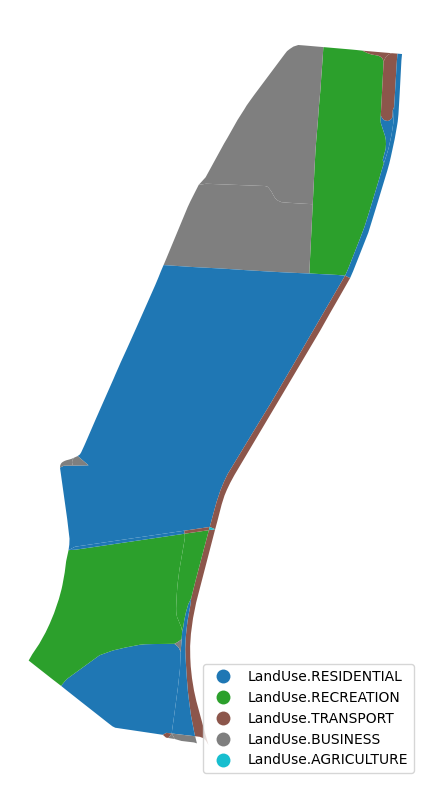

In [15]:
optimizer.plot(expanded_result[0]['gdf'], figsize=(10,10), legend_kwds={'loc':'lower right'})